In [2]:
from qfunction import QFunction


class LinearQFunction(QFunction):
    def __init__(self, features, weights=None, default=0.0):
        self.features = features
        if weights is None:
            num_actions = features.num_actions()
            num_features = features.num_features()
            self.weights = [default] * (num_actions * num_features)

    def update(self, state, action, delta):
        # update the weights
        feature_values = self.features.extract(state, action)
        for i in range(len(self.weights)):
            self.weights[i] = self.weights[i] + (delta * feature_values[i])

    def get_q_value(self, state, action):
        q_value = 0.0
        feature_values = self.features.extract(state, action)
        for i in range(len(feature_values)):
            q_value += feature_values[i] * self.weights[i]
        return q_value

In [1]:
class FeatureExtractor:
    def extract_features(self, state, action):
        abstract

In [3]:
from feature_extractor import FeatureExtractor
from gridworld import GridWorld


class GridWorldFeatureExtractor(FeatureExtractor):

    def __init__(self, mdp):
        self.mdp = mdp

    def num_features(self):
        return 3

    def num_actions(self):
        return len(self.mdp.get_actions())

    def extract(self, state, action):
        goal = (self.mdp.width - 1, self.mdp.height - 1)
        x = 0
        y = 1
        e = 0.01
        feature_values = []
        for a in self.mdp.get_actions():
            if a == action and state != GridWorld.TERMINAL:
            # Calculate the direction (angle) from the current state to the goal
                direction_to_goal = np.arctan2(goal[y] - state[y], goal[x] - state[x])
        
        # Calculate distance to the goal
                distance_to_goal = np.sqrt((goal[x] - state[x]) ** 2 + (goal[y] - state[y]) ** 2)
        
        # Include features for direction and distance
                feature_values.append(np.sin(direction_to_goal))  # Sine of direction
                feature_values.append(np.cos(direction_to_goal))  # Cosine of direction
                feature_values.append(distance_to_goal)
            else:
                for _ in range(0, self.num_features() - 3):  # Subtract 3 for original features
                    feature_values.append(0.0)
        return feature_values

In [3]:
class MultiArmedBandit():

    """ Select an action for this state given from a list given a Q-function """

    def select(self, state, actions, qfunction):
        abstract

    """ Reset a multi-armed bandit to its initial configuration """

    def reset(self):
        self.__init__()
        
from collections import defaultdict
import random
from qtable import QTable


""" Run a bandit algorithm for a number of episodes, with each episode
being a set length.
"""

def run_bandit(bandit, episodes=2000, episode_length=1000, drift=True):

    # The actions available
    actions = [0, 1, 2, 3, 4]

    # A dummy state
    state = 1

    rewards = []
    for _ in range(0, episodes):
        bandit.reset()

        # The probability of receiving a payoff of 1 for each action
        probabilities = [0.1, 0.3, 0.7, 0.2, 0.1]

        # The number of times each arm has been selected
        times_selected = defaultdict(lambda: 0)
        qtable = QTable()

        episode_rewards = []
        for step in range(0, episode_length):

            # Halfway through the episode, change the probabilities
            if drift and step == episode_length / 2:
                probabilities = [0.5, 0.2, 0.0, 0.3, 0.3]

            # Select an action using the bandit
            action = bandit.select(state, actions, qtable)

            # Get the reward for that action
            reward = 0
            if random.random() < probabilities[action]:
                reward = 5

            episode_rewards += [reward]

            times_selected[action] = times_selected[action] + 1
            qtable.update(
                state,
                action,
                (reward / times_selected[action])
                - (qtable.get_q_value(state, action) / times_selected[action]),
            )

        rewards += [episode_rewards]

    return rewards

import random
#from multi_armed_bandit.multi_armed_bandit import MultiArmedBandit


class EpsilonGreedy(MultiArmedBandit):
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon

    def reset(self):
        pass

    def select(self, state, actions, qfunction):
        # Select a random action with epsilon probability
        if random.random() < self.epsilon:
            return random.choice(actions)
        (arg_max_q, _) = qfunction.get_max_q(state, actions)
        return arg_max_q

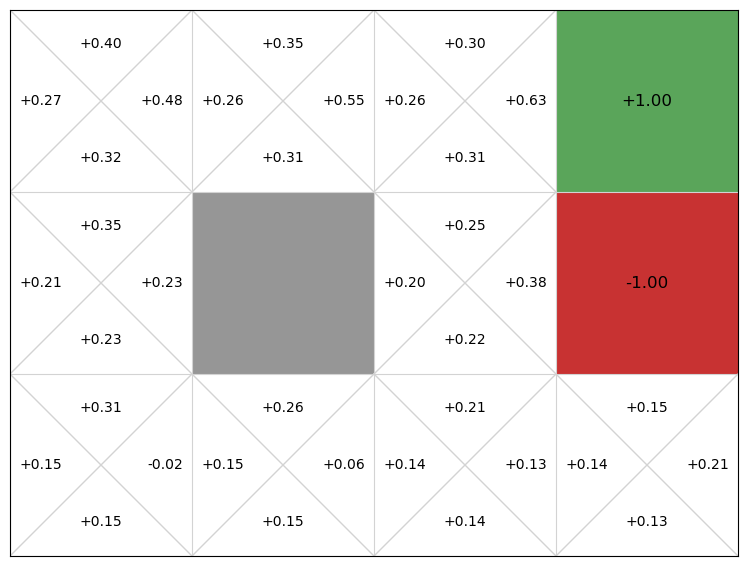

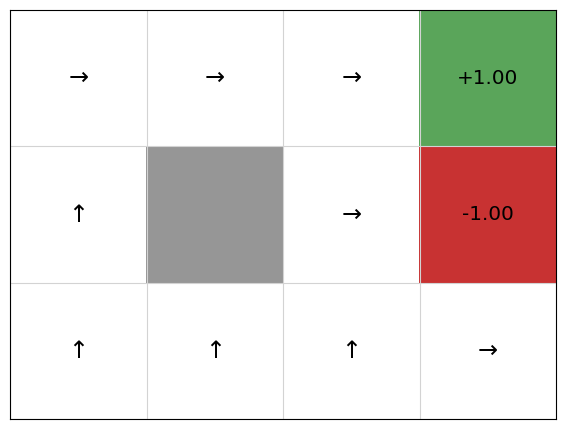

In [16]:
from gridworld import GridWorld
from qlearning import QLearning
from linear_qfunction import LinearQFunction
from gridworld_feature_extractor import GridWorldFeatureExtractor
#from multi_armed_bandit.epsilon_greedy import EpsilonGreedy

mdp = GridWorld()
features = GridWorldFeatureExtractor(mdp)
qfunction = LinearQFunction(features)
QLearning(mdp, EpsilonGreedy(), qfunction).execute()
policy = qfunction.extract_policy(mdp)
mdp.visualise_q_function(qfunction)
mdp.visualise_policy(policy)

In [17]:
from feature_extractor import FeatureExtractor
from gridworld import GridWorld


class GridWorldBetterFeatureExtractor(FeatureExtractor):

    def __init__(self, mdp):
        self.mdp = mdp

    def num_features(self):
        return 5

    def num_actions(self):
        return len(self.mdp.get_actions())

    def extract(self, state, action):
        goal = (self.mdp.width - 1, self.mdp.height - 1)
        x = 0
        y = 1
        e = 0.01
        feature_values = []
        for a in self.mdp.get_actions():
            if a == action and state != GridWorld.TERMINAL:
                feature_values += [(state[x] + e) / (goal[x] + e)]
                feature_values += [(state[y] + e) / (goal[y] + e)]
                feature_values += [
                    (goal[x] - state[x] + goal[y] - state[y] + e)
                    / (goal[x] + goal[y] + e)
                ]
                # Features to determine if we are in goal row or column
                feature_values += [1 if goal[x] == state[x] else 0]
                feature_values += [1 if goal[y] == state[y] else 0]
            else:
                for _ in range(0, self.num_features()):
                    feature_values += [0.0]
        return feature_values

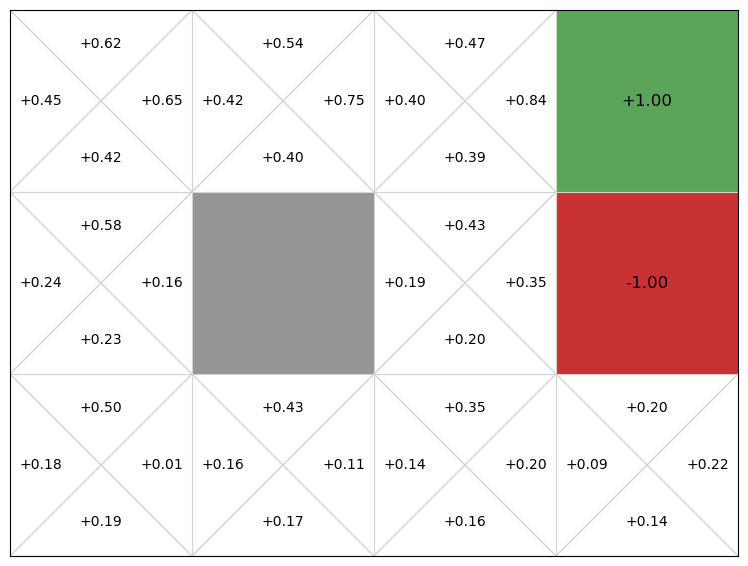

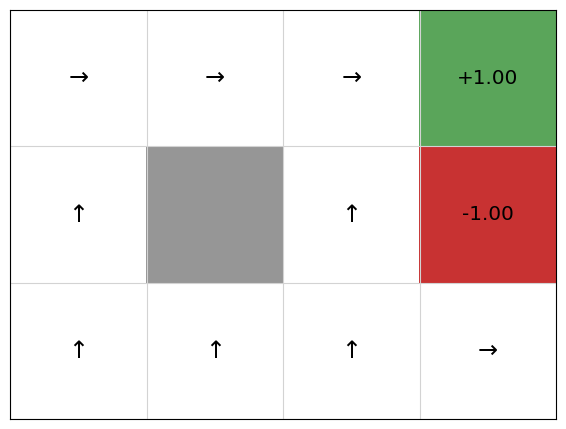

In [129]:
from gridworld_better_feature_extractor import GridWorldBetterFeatureExtractor

mdp = GridWorld()
features = GridWorldBetterFeatureExtractor(mdp)
qfunction = LinearQFunction(features)
QLearning(mdp, EpsilonGreedy(), qfunction).execute()
policy = qfunction.extract_policy(mdp)
mdp.visualise_q_function(qfunction)
mdp.visualise_policy(policy)

In [50]:
mdp.get_states()

[('terminal', 'terminal'),
 (0, 0),
 (0, 1),
 (0, 2),
 (1, 0),
 (1, 2),
 (2, 0),
 (2, 1),
 (2, 2),
 (3, 0),
 (3, 1),
 (3, 2)]

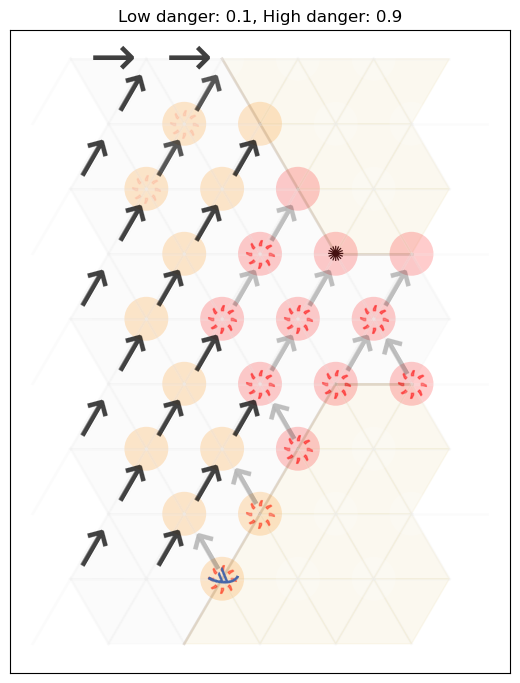

In [20]:
from qlearning import QLearning
from linear_qfunction import LinearQFunction
from ccross_feature_extractor import CCrossFeatureExtractor
#from multi_armed_bandit.epsilon_greedy import EpsilonGreedy
import contested_crossing


mdp = contested_crossing.ContestedCrossing()
features = CCrossFeatureExtractor(mdp)
qfunction = LinearQFunction(features)
QLearning(mdp, EpsilonGreedy(), qfunction).execute()
policy = qfunction.extract_policy(mdp)
mdp.visualise_as_image(policy=policy,mode=0,title="Low danger: {0}, High danger: {1}".format(mdp.low_danger,mdp.high_danger),plot=True)

In [15]:
import numpy as np
from feature_extractor import FeatureExtractor
from gridworld import GridWorld

class GridWorldBiditFeatureExtractor(FeatureExtractor):
    def __init__(self, mdp):
        self.mdp = mdp
        self.forbidden_states = [(1, 1)]  # Define your forbidden states

    def num_features(self):
        return 10  # Adjust the number of features

    def num_actions(self):
        return len(self.mdp.get_actions())

    def extract(self, state, action):
        goal = (self.mdp.width - 1, self.mdp.height - 1)
        x = 0
        y = 1
        e = 0.01
        feature_values = []

        for a in self.mdp.get_actions():
            if a == action and state != GridWorld.TERMINAL:
                # Check if the next state after taking 'action' is forbidden
                next_state = self.mdp.get_transitions(state, action)
                is_forbidden = next_state in self.forbidden_states

                # Feature values for state and action
                feature_values += [(state[x] + e) / (goal[x] + e)]
                feature_values += [(state[y] + e) / (goal[y] + e)]
                feature_values += [
                    (goal[x] - state[x] + goal[y] - state[y] + e)
                    / (goal[x] + goal[y] + e)
                ]
                feature_values += [1 if goal[x] == state[x] else 0]
                feature_values += [1 if goal[y] == state[y] else 0]
                feature_values += [1 if action == 'UP' and state[x] < goal[x] and state[y] < goal[y] else 0]
                

                # Additional feature to indicate if the next state is forbidden
                feature_values += [1 if is_forbidden else 0]

                # Calculate direction to the nearest forbidden state
                nearest_forbidden_state = self.find_nearest_forbidden(state)
                direction_to_forbidden = self.calculate_direction(state, nearest_forbidden_state)
                feature_values += [direction_to_forbidden]

                # New feature: Angle to goal
                angle_to_goal = np.arctan2(goal[y] - state[y], goal[x] - state[x])
                feature_values += [angle_to_goal]

                # New feature: Check if the resulting state is valid
                valid_state = self.is_valid_state(state, action)
                feature_values += [1 if valid_state else 0]

            else:
                for _ in range(0, self.num_features()):
                    feature_values += [0.0]

        return feature_values

    def find_nearest_forbidden(self, state):
        nearest_distance = float('inf')
        nearest_forbidden = None
        for forbidden_state in self.forbidden_states:
            distance = np.linalg.norm(np.array(state) - np.array(forbidden_state))
            if distance < nearest_distance:
                nearest_distance = distance
                nearest_forbidden = forbidden_state
        return nearest_forbidden

    def calculate_direction(self, from_state, to_state):
        direction = np.arctan2(to_state[1] - from_state[1], to_state[0] - from_state[0])
        return direction

    def is_valid_state(self, state, action):
        action_mapping = {
                    '▲': (0,1),
                    '▼': (0,-1),
                    '◄': (-1,0),
                    '►': (1,0),
                    'terminate': (3,2)
        }
        next_state = (state[0] + action_mapping[action][0], state[1] + action_mapping[action][1])
        return next_state not in self.mdp.blocked_states and next_state in self.mdp.get_states()


In [56]:
# class GridWorldBiditFeatureExtractor(FeatureExtractor):
#     def __init__(self, mdp):
#         self.mdp = mdp
#         self.forbidden_states = [(1, 1)]  # Define your forbidden states

#     def num_features(self):
#         return 10  # Increase the number of features

#     def num_actions(self):
#         return len(self.mdp.get_actions())

#     def extract(self, state, action):
#         goal = (self.mdp.width - 1, self.mdp.height - 1)
#         x = 0
#         y = 1
#         e = 0.01
#         feature_values = []

#         for a in self.mdp.get_actions():
#             if a == action and state != GridWorld.TERMINAL:
#                 # Check if the next state after taking 'action' is forbidden
#                 next_state = self.mdp.get_transitions(state, action)
#                 is_forbidden = next_state in self.forbidden_states
                
#                 # Feature values for state and action
#                 feature_values += [(state[x] + e) / (goal[x] + e)]
#                 feature_values += [(state[y] + e) / (goal[y] + e)]
#                 feature_values += [
#                     (goal[x] - state[x] + goal[y] - state[y] + e)
#                     / (goal[x] + goal[y] + e)
#                 ]
#                 feature_values += [1 if goal[x] == state[x] else 0]
#                 feature_values += [1 if goal[y] == state[y] else 0]
#                 feature_values += [1 if action == 'UP' and state[x] < goal[x] and state[y] < goal[y] else 0]
#                 feature_values += [1 if state[x] < self.mdp.width / 2 and state[y] < self.mdp.height / 2 else 0]
                
#                 # Additional feature to indicate if the next state is forbidden
#                 feature_values += [1 if is_forbidden else 0]

#                 # New feature: 1 if the action is moving towards the goal (up and to the right), 0 otherwise
#                 feature_values += [1 if action == 'UP' and state[x] < goal[x] and state[y] < goal[y] else 0]

#                 # New feature: 1 if the action is moving away from the goal (down and to the left), 0 otherwise
#                 feature_values += [1 if action == 'DOWN' and state[x] > goal[x] and state[y] > goal[y] else 0]

#             else:
#                 for _ in range(0, self.num_features()):
#                     feature_values += [0.0]

#         return feature_values


Length of self.weights: 50
Length of feature_values: 50
Length of self.weights: 50
Length of feature_values: 50
Length of self.weights: 50
Length of feature_values: 50
Length of self.weights: 50
Length of feature_values: 50
Length of self.weights: 50
Length of feature_values: 50
Length of self.weights: 50
Length of feature_values: 50
Length of self.weights: 50
Length of feature_values: 50
Length of self.weights: 50
Length of feature_values: 50
Length of self.weights: 50
Length of feature_values: 50
Length of self.weights: 50
Length of feature_values: 50
Length of self.weights: 50
Length of feature_values: 50
Length of self.weights: 50
Length of feature_values: 50
Length of self.weights: 50
Length of feature_values: 50
Length of self.weights: 50
Length of feature_values: 50
Length of self.weights: 50
Length of feature_values: 50
Length of self.weights: 50
Length of feature_values: 50
Length of self.weights: 50
Length of feature_values: 50
Length of self.weights: 50
Length of feature_val

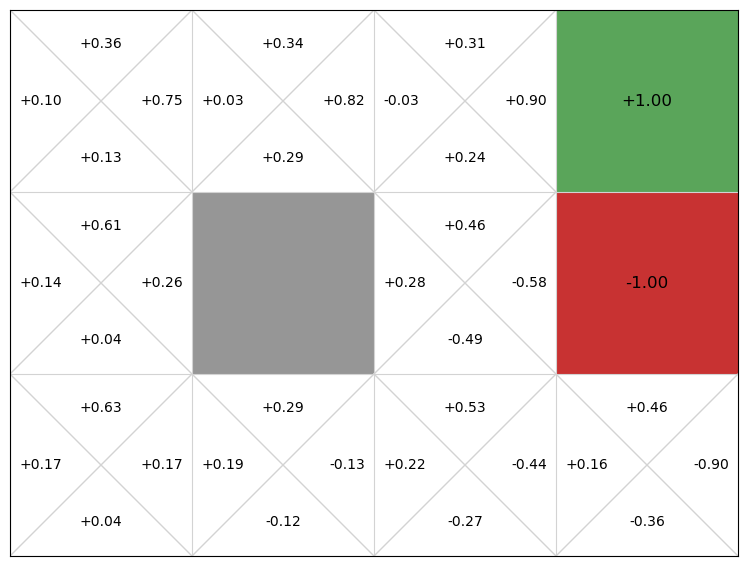

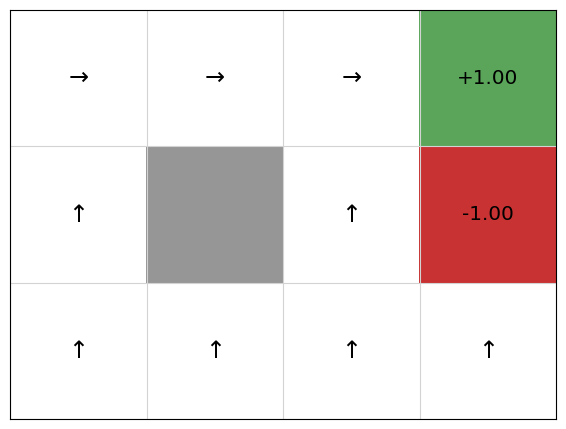

In [20]:
#from directional_proximity_feature_extractor import GridWorldBetterFeatureExtractor
from gridworld import GridWorld
from qlearning import QLearning
from linear_qfunction import LinearQFunction
#from gridworld_feature_extractor import GridWorldFeatureExtractor
import random
random.seed(60)   #100 and 51,54
mdp = GridWorld()
features = GridWorldBiditFeatureExtractor(mdp)
qfunction = LinearQFunction(features)
QLearning(mdp, EpsilonGreedy(), qfunction).execute()
policy = qfunction.extract_policy(mdp)
mdp.visualise_q_function(qfunction)
mdp.visualise_policy(policy)


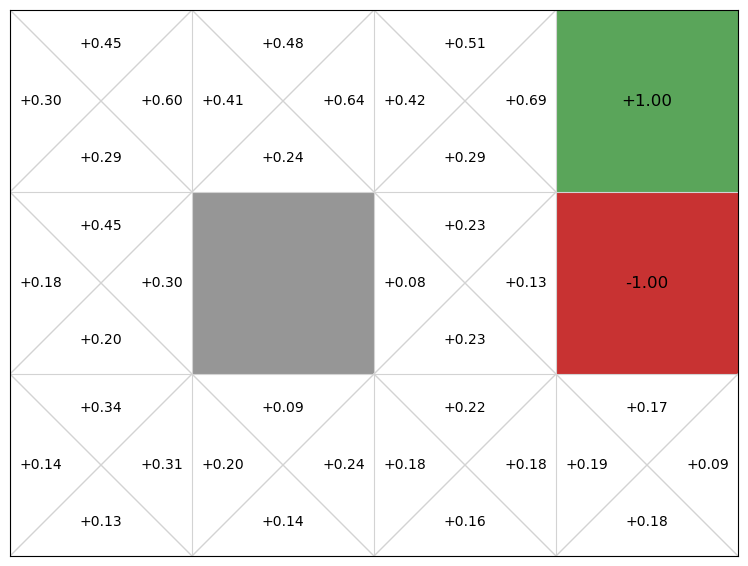

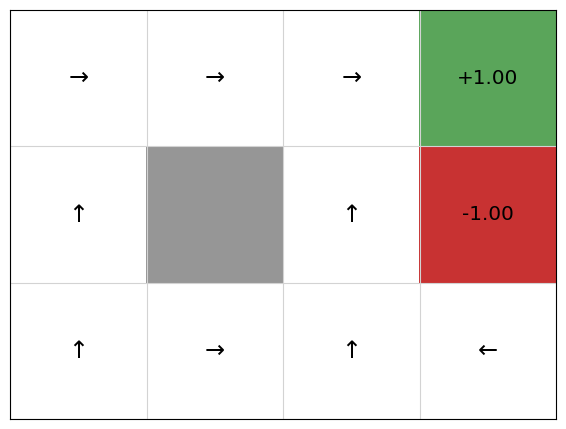

In [22]:
#from directional_proximity_feature_extractor import GridWorldBetterFeatureExtractor
from gridworld import GridWorld
from qlearning import QLearning
from nonlinear_qfunction import NonLinearQFunction
from gridworld_feature_extractor import GridWorldFeatureExtractor
import random
random.seed(42)   #56 and 55, 42
mdp = GridWorld()
features = GridWorldBiditFeatureExtractor(mdp)
qfunction = NonLinearQFunction(features)
QLearning(mdp, EpsilonGreedy(), qfunction).execute()
policy = qfunction.extract_policy(mdp)
mdp.visualise_q_function(qfunction)
mdp.visualise_policy(policy)


In [47]:
# import numpy as np
# class GridWorldMyFeatureExtractor(FeatureExtractor):

#     def __init__(self, mdp):
#         self.mdp = mdp

#     def num_features(self):
#         return 6

#     def num_actions(self):
#         return len(self.mdp.get_actions())

#     def extract(self, state, action):
#         goal = (self.mdp.width - 1, self.mdp.height - 1)
#         x = 0
#         y = 1
#         e = 0.01
#         feature_values = []
#         for a in self.mdp.get_actions():
#             if a == action and state != GridWorld.TERMINAL:
#                 feature_values += [(state[x] + e) / (goal[x] + e)]
#                 feature_values += [(state[y] + e) / (goal[y] + e)]
                
#                 # Euclidean distance computation
#                 euclidean_distance = np.sqrt((state[x] - goal[x])**2 + (state[y] - goal[y])**2)
                
#                 # Normalize Euclidean distance to [0, 1] range
#                 min_distance = 0.0  # Minimum possible distance
#                 max_distance = np.sqrt((self.mdp.width-1)**2 + (self.mdp.height-1)**2)  # Maximum possible distance
#                 normalized_distance = (euclidean_distance - min_distance) / (max_distance - min_distance)
                
#                 feature_values += [euclidean_distance]
                
#                 # Features to determine if we are in goal row or column
#                 feature_values += [1 if goal[x] == state[x] else 0]
#                 feature_values += [1 if goal[y] == state[y] else 0]
                
#                 # Check whether resulting state is valid
#                 action_mapping = {
#                     '▲': (0,1),
#                     '▼': (0,-1),
#                     '◄': (-1,0),
#                     '►': (1,0),
#                     'terminate': (5,5)
#                         }
#                 feature_values += [1 if (state[0]+action_mapping[a][0],state[1]+action_mapping[a][1]) not in self.mdp.blocked_states and
#                                    (state[0]+action_mapping[a][0], state[1]+action_mapping[a][1]) in self.mdp.get_states() else 0]

                
                
                
                


                
                
                
#             else:
#                 for _ in range(0, self.num_features()):
#                     feature_values += [0.0]
#         return feature_values


Length of self.weights: 30
Length of feature_values: 30
Length of self.weights: 30
Length of feature_values: 30
Length of self.weights: 30
Length of feature_values: 30
Length of self.weights: 30
Length of feature_values: 30
Length of self.weights: 30
Length of feature_values: 30
Length of self.weights: 30
Length of feature_values: 30
Length of self.weights: 30
Length of feature_values: 30
Length of self.weights: 30
Length of feature_values: 30
Length of self.weights: 30
Length of feature_values: 30
Length of self.weights: 30
Length of feature_values: 30
Length of self.weights: 30
Length of feature_values: 30
Length of self.weights: 30
Length of feature_values: 30
Length of self.weights: 30
Length of feature_values: 30
Length of self.weights: 30
Length of feature_values: 30
Length of self.weights: 30
Length of feature_values: 30
Length of self.weights: 30
Length of feature_values: 30
Length of self.weights: 30
Length of feature_values: 30
Length of self.weights: 30
Length of feature_val

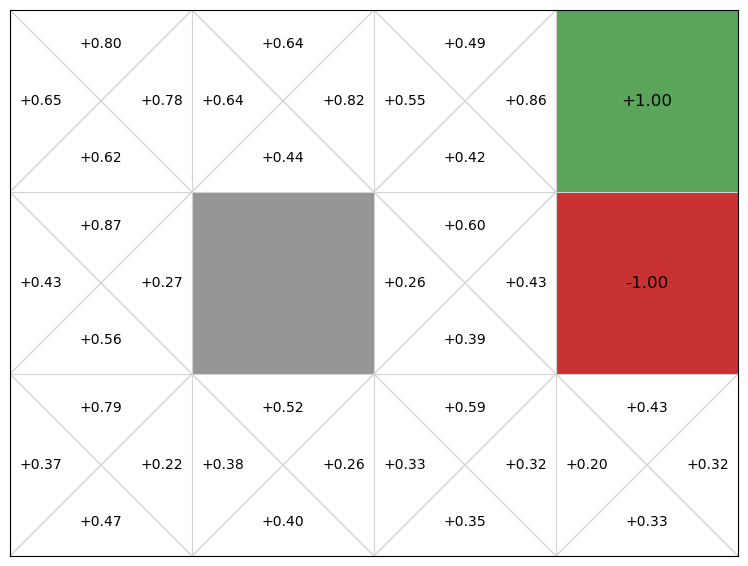

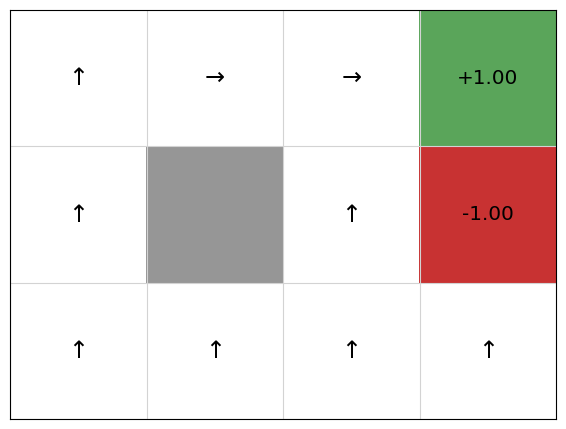

In [54]:
# #from directional_proximity_feature_extractor import GridWorldBetterFeatureExtractor
# import random
# #random.seed(44)
# mdp = GridWorld()
# features = GridWorldMyFeatureExtractor(mdp)
# qfunction = LinearQFunction(features)
# QLearning(mdp, EpsilonGreedy(), qfunction).execute()
# policy = qfunction.extract_policy(mdp)
# mdp.visualise_q_function(qfunction)
# mdp.visualise_policy(policy)

In [34]:
mdp.get_actions()

['▲', '▼', '◄', '►', 'terminate']

In [84]:
mdp.initial_state

(0, 0)

In [35]:
action_mapping = {
    '▲': (0,1),
    '▼': (0,-1),
    '◄': (-1,0),
    '►': (1,0),
    'terminate': 4
}


